In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('./df_guardado_clean.csv')

In [27]:
df.head()

,order_id,Fecha,Hora,avg_actual_delivery_time_minutes,avg_promised_delivery_time_minutes,to_pickup,to_dropoff,Vendor_id,llueve,ph
0,131748347,Viernes,13,69.100000,31.900000,1.348,0.489,1,1,0
1,131749603,Viernes,13,36.700000,30.883333,0.359,0.513,1,1,0
2,131748367,Viernes,13,32.833333,32.666667,0.735,0.684,1,1,0
3,131743177,Viernes,12,39.383333,40.600000,0.166,2.121,1,1,0
4,131738512,Viernes,11,29.450000,35.883333,2.924,2.898,1,1,0


## ERROR que trae el modelo actual

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
Z = df[df['Vendor_id']<12]
RMSE = np.sqrt(mean_squared_error(Z['avg_actual_delivery_time_minutes'], Z['avg_promised_delivery_time_minutes'])).round(2)
MAE = mean_absolute_error(Z['avg_actual_delivery_time_minutes'], Z['avg_promised_delivery_time_minutes']).round(2)
RMSE, MAE

(12.04, 8.2)

##### Teniendo en cuente que revise manualmente los restaurantes responsables del 25% de los pedidos,
##### paso a hacer un modelo reducido

In [30]:
X = df[df['Vendor_id']<12].drop(['avg_actual_delivery_time_minutes','avg_promised_delivery_time_minutes'], axis=1)
X = pd.get_dummies(X, columns=['Vendor_id', 'Fecha']).values

In [31]:
X.shape

(39172, 24)

In [32]:
y = df[df['Vendor_id']<12]['avg_actual_delivery_time_minutes'].values

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=912)

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

In [36]:
X_train = scaler.fit_transform(X_train)

In [37]:
X_test = scaler.transform(X_test)

# Creacion de la Red Neuronal

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1)

In [40]:
model = Sequential()

# input layer
model.add(Dense(25,  activation='relu'))

# hidden layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))

# hidden layer
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))

# hidden layer
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(1, kernel_initializer='normal'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

## Fit Modelo

In [41]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=25, callbacks=[early_stop])

Train on 31337 samples, validate on 7835 samples
Epoch 1/200
31337/31337 [==============================] - 5s 166us/sample - loss: 277.1234 - val_loss: 187.2222
Epoch 2/200
31337/31337 [==============================] - 4s 129us/sample - loss: 220.7853 - val_loss: 188.0343
Epoch 3/200
31337/31337 [==============================] - 4s 125us/sample - loss: 216.7122 - val_loss: 177.6636
Epoch 4/200
31337/31337 [==============================] - 5s 151us/sample - loss: 213.7578 - val_loss: 179.3037
Epoch 5/200
31337/31337 [==============================] - 4s 142us/sample - loss: 209.5244 - val_loss: 184.5381
Epoch 6/200
31337/31337 [==============================] - 4s 136us/sample - loss: 207.7873 - val_loss: 178.4378
Epoch 7/200
31337/31337 [==============================] - 4s 132us/sample - loss: 208.2204 - val_loss: 180.5582
Epoch 00007: early stopping


In [42]:
model.history.history

{'loss': [277.12336003222305,
  220.78530990559685,
  216.71220097065688,
  213.75782741550648,
  209.52441709823796,
  207.78725719552332,
  208.2204349564202],
 'val_loss': [187.22222674478752,
  188.03432238931174,
  177.66363210623328,
  179.30372898854034,
  184.53807228297737,
  178.4378206390595,
  180.55821405007873]}

In [43]:
loss = pd.DataFrame(model.history.history)

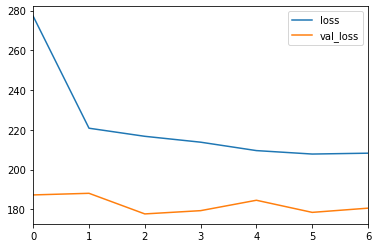

In [44]:
loss.plot()

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [46]:
y_pred = model.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
MAE = mean_absolute_error(y_test, y_pred).round(2)
RMSE, MAE

(13.44, 9.4)